## Run community detection experiments

Do this for Louvain algorithm.

And hopefully eADAGE & coexpression networks, if time...

In [1]:
import os
import random

import numpy as np
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import seaborn as sns

from sample_nodes import (
    sample_degree_matched,
    sort_by_degree,
)

random.seed(1) # igraph uses Python RNG
np.random.seed(1)

In [2]:
# relevant file paths
data_dir = './data'
edge_list = os.path.join(data_dir, 'edge_list_processed_unsigned.csv')

# map of Pa gene names to generic/not generic status, generated by Alex
generic_gene_map = os.path.join('..', 'pseudomonas_analysis', 'annot_df.tsv')

# script parameters
NUM_NODE_SAMPLES = 1000 # number of degree-matched node samples for permutation test
NUM_BINS = 100 # number of bins to divide nodes into, for sampling

In [3]:
graph_df = pd.read_csv(edge_list)
graph_df.head()

,from,to,weight
0,PA0001,PA0002,0.578872
1,PA0001,PA0548,0.510323
2,PA0001,PA0963,0.561494
3,PA0001,PA3637,0.512365
4,PA0001,PA5554,0.554768


In [4]:
G = ig.Graph.TupleList(graph_df.values,
                       weights=True,
                       directed=False)

In [5]:
# make sure vertex/edge properties exist
print(G.es['weight'][:5])

[0.578871792667748, 0.510322953238081, 0.561494130101994, 0.512364523924246, 0.554767556277657]


In [6]:
annot_df = pd.read_csv(generic_gene_map, sep='\t', index_col=0)
annot_df.head()

,label
PA0001,0
PA0002,0
PA0003,0
PA0004,0
PA0005,0


In [7]:
is_generic = [int(annot_df.loc[v['name'], 'label']) for v in G.vs]
G.vs['is_generic'] = is_generic

In [8]:
# community detection using Louvain modularity optimization
partition = G.community_multilevel(weights=G.es['weight'], return_levels=False)
# plot?

In [9]:
# get dataframe mapping Pa genes to communities
def graph_partition_to_df(G, partition):
    clusters = []
    for label, vl in enumerate(partition):
        clusters += [(G.vs['name'][v],
                      label,
                      G.degree(v),
                      G.vs['is_generic'][v]) for v in vl]
    return pd.DataFrame(clusters,
                        columns=['gene', 'label', 'degree', 'is_generic'])

labels_df = graph_partition_to_df(G, partition)
print(len(labels_df.label.unique()))
labels_df.sort_values(by='degree', ascending=False).head()

174


,gene,label,degree,is_generic
24,PA4238,0,209,0
27,PA4245,0,201,0
28,PA4247,0,192,0
65,PA4252,0,181,0
25,PA4239,0,180,0


In [10]:
# simultaneously sort nodes and degrees by degree, ascending
nodes, degrees, is_generic = sort_by_degree(labels_df.gene.values,
                                            labels_df.degree.values,
                                            labels_df.is_generic.values)

# sample a few times and add results to df
for it in range(NUM_NODE_SAMPLES):
    s_nodes, s_degrees, __ = sample_degree_matched(nodes, degrees, is_generic,
                                                   num_bins=NUM_BINS)
    sampled = [1 if gene in s_nodes else 0 for gene in labels_df.gene]
    labels_df['sampled_{}'.format(it)] = sampled

labels_df.sort_values(by='degree', ascending=False).iloc[:5, :5]

,gene,label,degree,is_generic,sampled_0
24,PA4238,0,209,0,0
27,PA4245,0,201,0,0
28,PA4247,0,192,0,0
65,PA4252,0,181,0,0
25,PA4239,0,180,0,0


In [11]:
generic_count_df = (
    labels_df.groupby('label').sum()
             .drop(columns=['degree'])
)
print(generic_count_df.shape)
generic_count_df.sort_values(by='is_generic', ascending=False).iloc[:5, :5]

(174, 1001)


,is_generic,sampled_0,sampled_1,sampled_2,sampled_3
label,,,,,
3,82,24,24,19,25
14,48,12,13,18,13
0,44,50,47,46,46
10,43,9,13,18,16
49,30,4,6,5,4


In [12]:
nonzero_counts_df = pd.DataFrame(
    [np.count_nonzero(generic_count_df, axis=0)],
    columns=generic_count_df.columns
)
nonzero_counts_df.iloc[:, :5]

,is_generic,sampled_0,sampled_1,sampled_2,sampled_3
0,42,47,50,53,52


Text(0.5, 1.0, 'Number of communities, generic genes vs. 1000 degree-matched samples')

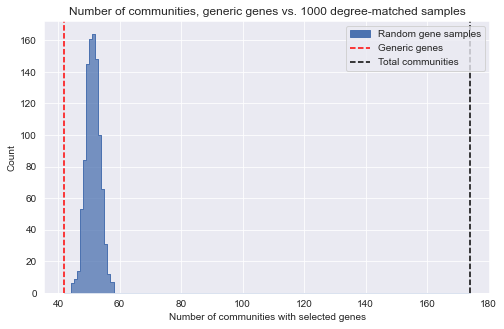

In [13]:
n_generic_groups = nonzero_counts_df.iloc[0, 0]
n_total_groups = len(labels_df.label.unique())

sns.set({'figure.figsize': (8, 5)})

sns.histplot(nonzero_counts_df.iloc[0, 1:].values,
             element='step',
             bins=np.arange(n_generic_groups, n_total_groups+1))
line1 = plt.gca().axvline(x=n_generic_groups,
                         linestyle='--', color='red')
line2 = plt.gca().axvline(x=n_total_groups,
                          linestyle='--', color='black')
plt.xlabel('Number of communities with selected genes')
plt.legend(handles=[mpatches.Patch(color=sns.color_palette()[0]), line1, line2],
           labels=['Random gene samples', 'Generic genes', 'Total communities'],
           loc='upper right')
plt.title('Number of communities, generic genes vs. {} degree-matched samples'.format(
    NUM_NODE_SAMPLES
))